In [127]:
%matplotlib inline

In [8]:
import numpy as np
import pandas as pd

#　統計用ツール
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from patsy import dmatrices

#　自作の空間統計用ツール
from spatialstat import *

#描画
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot

#クラスター
from sklearn import mixture

# クラスター分けしてOLS

### 1 CSVをpandasで取り込む。

In [576]:
df = pd.read_csv('bukken_data.csv')
df = df[:][df['pay'] < 300000]
df = df.reset_index(drop=True)

In [417]:
df.columns

Index(['index', 'apart_dummy', 'building_year', 'dk', 'fX', 'fY', 'floor', 'k',
       'lk', 'mansyon_dumy', 'new_dummy', 'pay', 'published_date', 'r',
       'rc_dummy', 'room_nums', 'sdk', 'sk', 'sldk', 'slk',
       'south_direction_dummy', 'square', 'teiki_syakuya_dummy',
       'walk_minute_dummy'],
      dtype='object')

### 2 普通のOLS

In [574]:
vars = ['pay', 'square', 'k', 'lk', 'dk', 'sdk', 'sldk', 'south_direction_dummy', 'building_year', 
        'new_dummy', 'mansyon_dumy', 'teiki_syakuya_dummy', 'walk_minute_dummy', 'r', 'rc_dummy', 'room_nums']
eq = fml_build(vars)

y, X = dmatrices(eq, data=df, return_type='dataframe')

logy = np.log(y)

model = sm.OLS(logy, X, intercept=True)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     453.8
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:59:55   Log-Likelihood:                 660.63
No. Observations:                1427   AIC:                            -1293.
Df Residuals:                    1413   BIC:                            -1220.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.64

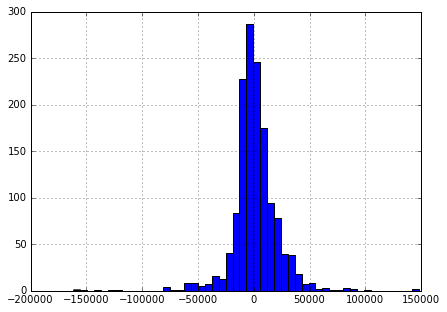

In [575]:
pred = results.predict()
evl = df['pay'] - np.exp(pred)
evl.hist(figsize=(7,5), bins=50)

### 3 クラスターの作成

In [442]:
n=20

cluster_array = np.array([df['pay'], df['fX']*100, df['fY']*100])
gmm = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(cluster_array.T)
dum = pd.get_dummies(gmm.predict(cluster_array.T))
dum_nam = ['d%s'%i for i in range(n)] 
dum.columns = dum_nam

### 4 クラスター分類を利用したOLS推定

リストから回帰式を生成する関数。spatialstat内にあるのでimportすれば使える。

In [443]:
df_with_dummy = pd.concat((df, dum), axis=1)

vars = ['pay', 'square', 'k', 'lk', 'dk', 'sdk', 'sldk', 'south_direction_dummy', 'building_year', 
        'new_dummy', 'mansyon_dumy', 'teiki_syakuya_dummy', 'walk_minute_dummy', 'r', 'rc_dummy', 'room_nums']
vars = vars + dum_nam[:-1]

eq = fml_build(vars)

y, X = dmatrices(eq, data=df_with_dummy, return_type='dataframe')

logy = np.log(y)

model = sm.GLS(logy, X, intercept=True)
results = model.fit()
print(results.summary())

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.949
Model:                            GLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     818.1
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:36:00   Log-Likelihood:                 1617.3
No. Observations:                1427   AIC:                            -3169.
Df Residuals:                    1394   BIC:                            -2995.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.75

OLSによる予測値。

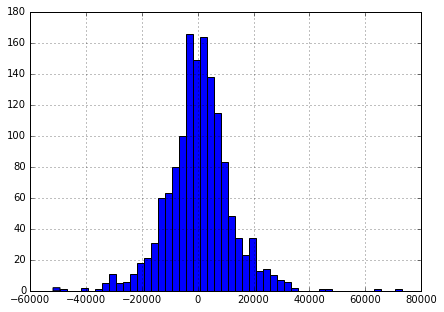

In [445]:
pred = results.predict()
evl = df['pay'] - np.exp(pred)
evl.hist(figsize=(7,5), bins=50)

In [425]:
df['pay']

0       176000
1       175000
2       171000
3       205200
4       176000
5       160000
6       170000
7       180000
8       130000
9       130000
10      135000
11      170000
12      170000
13      130000
14      160000
15      130000
16      130000
17      135000
18      130000
19      130000
20      135000
21      170000
22      230000
23      168000
24      170000
25      168000
26      260000
27      172000
28      163000
29      170000
         ...  
1397    170000
1398    140000
1399     90000
1400    110000
1401    100000
1402    158000
1403    110000
1404    180000
1405    129000
1406    225000
1407    229000
1408    207000
1409    110000
1410    108000
1411    115000
1412    160000
1413    198000
1414    100000
1415    245000
1416    100000
1417    100000
1418     85000
1419     85000
1420    108000
1421    270000
1422     90000
1423    250000
1424    110000
1425    100000
1426    130000
Name: pay, dtype: int64

In [426]:
print(evl.mean())
print(evl.std())

605.0953661598534
13427.107926219865


### 5 成約価格ではなく部屋面積を利用したクラスターの作成とOLS

In [436]:
n=100

cluster_array = np.array([df['square'], df['fX']*1000, df['fY']*1000])
gmm = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(cluster_array.T)
dum = pd.get_dummies(gmm.predict(cluster_array.T))
dum_nam = ['d%s'%i for i in range(n)] 
dum.columns = dum_nam

In [437]:
df_with_dummy = pd.concat((df, dum), axis=1)

vars = ['pay', 'square', 'k', 'lk', 'dk', 'sdk', 'sldk', 'south_direction_dummy', 'building_year', 
        'new_dummy', 'mansyon_dumy', 'teiki_syakuya_dummy', 'walk_minute_dummy', 'r', 'rc_dummy', 'room_nums']
vars = vars + dum_nam[:-1]

eq = fml_build(vars)

y, X = dmatrices(eq, data=df_with_dummy, return_type='dataframe')

logy = np.log(y)

model = sm.GLS(logy, X, intercept=True)
results = model.fit()
print(results.summary())

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.871
Model:                            GLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     79.16
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:35:10   Log-Likelihood:                 948.54
No. Observations:                1427   AIC:                            -1671.
Df Residuals:                    1314   BIC:                            -1076.
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.44

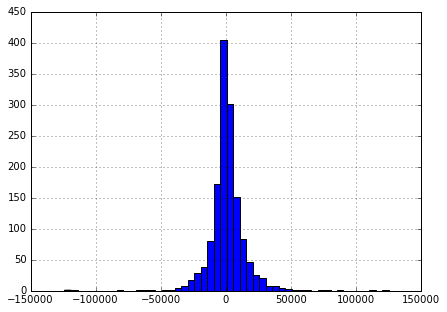

In [438]:
pred = results.predict()
evl = df['pay'] - np.exp(pred)
evl.hist(figsize=(7,5), bins=50)

### 6 無意味な乱数を利用したクラスターの作成とOLS

In [446]:
n=20

ransu = np.array([np.random.uniform() for i in range(len(df[:]))])
cluster_array = np.array([ransu, df['fX'], df['fY']])
gmm = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(cluster_array.T)
dum = pd.get_dummies(gmm.predict(cluster_array.T))
dum_nam = ['d%s'%i for i in range(n)] 
dum.columns = dum_nam

In [447]:
df_with_dummy = pd.concat((df, dum), axis=1)

vars = ['pay', 'square', 'k', 'lk', 'dk', 'sdk', 'sldk', 'south_direction_dummy', 'building_year', 
        'new_dummy', 'mansyon_dumy', 'teiki_syakuya_dummy', 'walk_minute_dummy', 'r', 'rc_dummy', 'room_nums']
vars = vars + dum_nam[:-1]

eq = fml_build(vars)

y, X = dmatrices(eq, data=df_with_dummy, return_type='dataframe')

logy = np.log(y)

model = sm.GLS(logy, X, intercept=True)
results = model.fit()
print(results.summary())

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.809
Model:                            GLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     184.6
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:36:35   Log-Likelihood:                 669.26
No. Observations:                1427   AIC:                            -1273.
Df Residuals:                    1394   BIC:                            -1099.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.64

これより単に変数を増やしたことが決定係数を上げたわけではないことがわかる。

### 7 クラスターの数 

In [448]:
def cluster_OLS(n):
    cluster_array = np.array([df['pay'], df['fX'], df['fY']])
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(cluster_array.T)
    dum = pd.get_dummies(gmm.predict(cluster_array.T))
    dum_nam = ['d%s'%i for i in range(n)] 
    dum.columns = dum_nam

    df_with_dummy = pd.concat((df, dum), axis=1)

    vars = ['pay', 'square', 'k', 'lk', 'dk', 'sdk', 'sldk', 'south_direction_dummy', 'building_year', 
            'new_dummy', 'mansyon_dumy', 'teiki_syakuya_dummy', 'walk_minute_dummy', 'r', 'rc_dummy', 'room_nums']
    vars = vars + dum_nam[:-1]

    eq = fml_build(vars)

    y, X = dmatrices(eq, data=df_with_dummy, return_type='dataframe')

    logy = np.log(y)

    model = sm.GLS(logy, X, intercept=True)
    results = model.fit()
    print(results.summary())
    
    return results

In [449]:
n=1

results = cluster_OLS(n)

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.807
Model:                            GLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     453.8
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:36:36   Log-Likelihood:                 660.63
No. Observations:                1427   AIC:                            -1293.
Df Residuals:                    1413   BIC:                            -1220.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.64

In [450]:
n=2

results = cluster_OLS(n)

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.818
Model:                            GLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     454.4
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:36:36   Log-Likelihood:                 704.80
No. Observations:                1427   AIC:                            -1380.
Df Residuals:                    1412   BIC:                            -1301.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.65

In [451]:
n=5

results = cluster_OLS(n)

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.890
Model:                            GLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     673.3
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:36:36   Log-Likelihood:                 1065.2
No. Observations:                1427   AIC:                            -2094.
Df Residuals:                    1409   BIC:                            -2000.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.56

In [452]:
n=10

results = cluster_OLS(n)

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.941
Model:                            GLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1026.
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:36:36   Log-Likelihood:                 1512.2
No. Observations:                1427   AIC:                            -2978.
Df Residuals:                    1404   BIC:                            -2857.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 6.04

In [453]:
n=15

results = cluster_OLS(n)

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.991
Model:                            GLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     5697.
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:36:37   Log-Likelihood:                 2847.6
No. Observations:                1427   AIC:                            -5639.
Df Residuals:                    1399   BIC:                            -5492.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 4.65

In [454]:
n=20

results = cluster_OLS(n)

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.993
Model:                            GLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     6436.
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:36:37   Log-Likelihood:                 3056.9
No. Observations:                1427   AIC:                            -6048.
Df Residuals:                    1394   BIC:                            -5874.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 6.27

In [455]:
n=25

results = cluster_OLS(n)

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.997
Model:                            GLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.084e+04
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:36:37   Log-Likelihood:                 3532.7
No. Observations:                1427   AIC:                            -6989.
Df Residuals:                    1389   BIC:                            -6789.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.69

In [456]:
n=30

results = cluster_OLS(n)

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.998
Model:                            GLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.383e+04
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:36:37   Log-Likelihood:                 3798.7
No. Observations:                1427   AIC:                            -7511.
Df Residuals:                    1384   BIC:                            -7285.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.78

### 8 成約価格だけ

In [463]:
def cluster_OLS_onlyprice(n):
    cluster_array = np.array([df['pay']])
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(cluster_array.T)
    dum = pd.get_dummies(gmm.predict(cluster_array.T))
    dum_nam = ['d%s'%i for i in range(n)] 
    dum.columns = dum_nam

    df_with_dummy = pd.concat((df, dum), axis=1)

    vars = ['pay', 'square', 'k', 'lk', 'dk', 'sdk', 'sldk', 'south_direction_dummy', 'building_year', 
            'new_dummy', 'mansyon_dumy', 'teiki_syakuya_dummy', 'walk_minute_dummy', 'r', 'rc_dummy', 'room_nums']
    vars = vars + dum_nam[:-1]

    eq = fml_build(vars)

    y, X = dmatrices(eq, data=df_with_dummy, return_type='dataframe')

    logy = np.log(y)

    model = sm.GLS(logy, X, intercept=True)
    results = model.fit()
    print(results.summary())
    
    return results

In [461]:
n=10

results = cluster_OLS_onlyprice(n)

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.947
Model:                            GLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1143.
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:37:29   Log-Likelihood:                 1585.4
No. Observations:                1427   AIC:                            -3125.
Df Residuals:                    1404   BIC:                            -3004.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.83

### 9 面積と位置でクラスター分類に加え値段による3区分

In [557]:
def cluster_OLS_honmei(n):
    dum1 = pd.DataFrame((df['pay'] < 100000)*1)
    dum1.columns = ['low']
    dum2 = pd.DataFrame((df['pay'] > 150000)*1)
    dum2.columns = ['high']
    dum = pd.concat((dum1, dum2), axis=1)
    
    df_with_dummy = pd.concat((df, dum), axis=1)
    
    cluster_array = np.array([df['square'], df['fX']*1000, df['fY']*1000])
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(cluster_array.T)
    dum = pd.get_dummies(gmm.predict(cluster_array.T))
    dum_nam = ['d%s'%i for i in range(n)] 
    dum.columns = dum_nam

    df_with_dummy = pd.concat((df_with_dummy, dum), axis=1)

    vars = ['pay', 'square', 'k', 'lk', 'dk', 'sdk', 'sldk', 'south_direction_dummy', 'building_year', 
            'new_dummy', 'mansyon_dumy', 'teiki_syakuya_dummy', 'walk_minute_dummy', 'r', 'rc_dummy', 
            'room_nums', 'low', 'high']
    vars = vars + dum_nam[:-1]

    eq = fml_build(vars)

    y, X = dmatrices(eq, data=df_with_dummy, return_type='dataframe')

    logy = np.log(y)

    model = sm.GLS(logy, X, intercept=True)
    results = model.fit()
    print(results.summary())
    
    return results

In [572]:
n=50

results = cluster_OLS_honmei(n)

                            GLS Regression Results                            
Dep. Variable:                    pay   R-squared:                       0.888
Model:                            GLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     168.0
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        22:58:53   Log-Likelihood:                 1047.1
No. Observations:                1427   AIC:                            -1964.
Df Residuals:                    1362   BIC:                            -1622.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 5.66

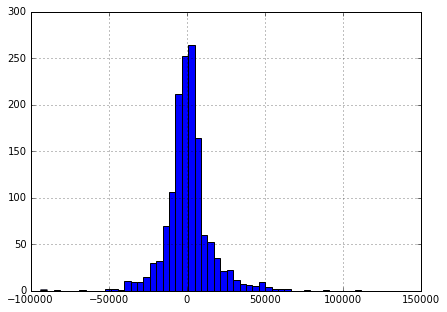

In [573]:
pred = results.predict()
evl = df['pay'] - np.exp(pred)
evl.hist(figsize=(7,5), bins=50)